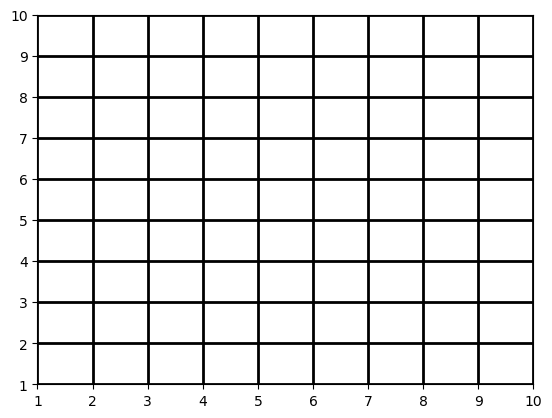

In [1]:
import gurobipy as gp
import matplotlib.pyplot as plt
import matplotlib.collections as cllc
from gurobipy import GRB

# Initialize grid:
plt.grid(color='black', linestyle='-', linewidth=2, zorder=0)
plt.xlim(1, 10)
plt.ylim(1, 10)

# Add a point on top of the grid:
def addPoint(x: int, y: int, col: str = 'red') -> cllc.PathCollection:
    plt.scatter(x, y, color=col, s=100, zorder=5)
    
# EX: addPoint(2, 3, 'blue')

In [2]:
grid_size = 10
coords = [(r,c) for r in range(1, grid_size+1) for c in range(1, grid_size+1)]

facility_names = ["school", "convenience", "hospital", "park", "fire", "police", "library", "gym", "bank", "post_office"]
max_facilities = {
    "school": 25,
    "hospital": 25,
    "police": 25,
    "fire": 25,
    "convenience": 25,
    "bank": 25,
    "gym": 25,
    "library": 25,
    "post_office": 25,
    "park": 25
}

def manhattan(a: int, b: int, c: int, d: int) -> int:
    return abs(a-c)+abs(b-d)

# Precompute distances!
dist = {(i, j): manhattan(i[0], i[1], j[0], j[1]) for i in coords for j in coords}

# Best and worst case:
T_min, T_max = 0, 2*(grid_size-1)

lo, hi = T_min, T_max
best_T = None
best_y = None

print(f"Starting binary search for T in range [{lo}, {hi}]...")

while lo <= hi:
    T = (lo + hi) // 2
    m = gp.Model(f"Cover_T_{T}")
    m.setParam("OutputFlag", 0)

    # y[name, i] if facility "name" is placed at i
    y = {
        name: {i: m.addVar(vtype=GRB.BINARY, name=f"y_{name}_{i}") for i in coords}
        for name in facility_names
    }

    # CONSTRAINT 1: Buildings can't overlap
    for i in coords:
        m.addConstr(gp.quicksum(y[name][i] for name in facility_names) <= 1)

    # CONSTRAINT 2: Enforce max # facilities
    for name in facility_names:
        m.addConstr(gp.quicksum(y[name][i] for i in coords) <= max_facilities[name])

    # CONSTRAINT 3: All points must be within 'T' of each type of facility
    for j in coords:
        close = [i for i in coords if dist[(i,j)] <= T]
        for name in facility_names:
            m.addConstr(gp.quicksum(y[name][i] for i in close) >= 1)

    m.setObjective(0, GRB.MINIMIZE) # Not seeking optimality; just feasible solutions
    m.optimize()

    if m.Status != GRB.INFEASIBLE: # Still feasible; attempt smaller distance 'T'
        best_T = T
        best_y = {name: {i: int(y[name][i].X + 0.5) for i in coords}
                  for name in facility_names}
        hi = T-1
    else: # Infeasible; 
        lo = T+1

# Results

if best_T is not None:
    total_facilities = sum(y_dict[i] for y_dict in best_y.values() for i in coords)
    
    print(f"✅ Final Result: Minimum Maximum Manhattan Distance (T_min) = **{best_T}**")
    print(f"Total facilities required: **{total_facilities}** (5 for each of the 10 types)")
else:
    sys.exit("❌ No feasible solution was found.")

Starting binary search for T in range [0, 18]...
Set parameter Username
Set parameter LicenseID to value 2699974
Academic license - for non-commercial use only - expires 2026-08-26

✅ Final Result: Minimum Maximum Manhattan Distance (T_min) = **3**
Total facilities required: **100** (5 for each of the 10 types)


In [3]:
# PHASE 2: Minimize facilities for the best found T

if best_T is None:
    print("\n❌ PHASE 1 failed to find a feasible T_min.")
else:
    print(f"\nPHASE 2: Minimizing Facilities for T_min = {best_T}")
    
    m_opt = gp.Model(f"Min_Facilities_T")
    m_opt.setParam("OutputFlag", 1)
    m_opt.setParam("MIPGap", 0)
    
    y_opt = {
        name: {i: m_opt.addVar(vtype=GRB.BINARY, name=f"y_opt_{name}_{i}") for i in coords}
        for name in facility_names
    }

    # NEW OBJECTIVE: Minimize total number of facilities
    m_opt.setObjective(
        gp.quicksum(y_opt[name][i] for name in facility_names for i in coords),
        GRB.MINIMIZE
    )
    
    # CONSTRAINT 1: No overlap
    for i in coords:
        m_opt.addConstr(gp.quicksum(y_opt[name][i] for name in facility_names) <= 1, name=f"Overlap_{i}")
    
    # CONSTRAINT 2: Max facilities
    for name in facility_names:
        m_opt.addConstr(gp.quicksum(y_opt[name][i] for i in coords) <= max_facilities[name], name=f"Max_{name}")
    
    # CONSTRAINT 3: Covering Constraint (Fixed maximum distance)
    for j in coords:
        for name in facility_names:
            # Use the fixed best T
            close_i = [i for i in coords if dist[(i,j)] <= best_T]
            m_opt.addConstr(gp.quicksum(y_opt[name][i] for i in close_i) >= 1, name=f"Cover_{name}_{j}")
            
    m_opt.optimize()


--- PHASE 2: Minimizing Facilities for T_min = 3 ---
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1110 rows, 1000 columns and 21600 nonzeros
Model fingerprint: 0x2d68436b
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 89.0000000
Presolve removed 120 rows and 0 columns
Presolve time: 0.04s
Presolved: 990 rows, 1000 columns, 19320 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 6.166667e+01, 5522 iterations, 0.63 seconds

school at (1,8)
school at (2,3)
school at (4,8)
school at (5,3)
school at (9,2)
school at (9,6)
school at (9,10)
convenience at (1,4)
convenience at (3,9)
convenience at (4,2)
convenience at (5,8)
convenience at (8,5)
convenience at (10,1)
convenience at (10,10)
hospital at (1,5)
hospital at (3,1)
hospital at (3,10)
hospital at (5,6)
hospital at (8,3)
hospital at (9,9)
hospital at (10,3)
park at (1,9)
park at (2,4)
park at (4,1)
park at (6,7)
park at (6,10)
park at (9,3)
park at (10,9)
fire at (1,3)
fire at (1,10)
fire at (4,6)
fire at (6,1)
fire at (7,8)
fire at (8,10)
fire at (10,4)
police at (1,2)
police at (1,7)
police at (5,5)
police at (5,10)
police at (7,1)
police at (8,9)
police at (10,5)
library at (2,6)
library at (2,10)
library at (3,2)
library at (6,9)
library at (7,4)
library at (9,1)
library at (10,8)
gym at (2,2)
gym at (2,9)
gym at (3,6)
gym at (7,3)
gym at (7,9)
gym at (8,1)
gym at (10,7)
bank at (1,1)
bank at (2,7)
bank at (4,10)
bank at (5,2)
bank at (6,4)
bank at (9

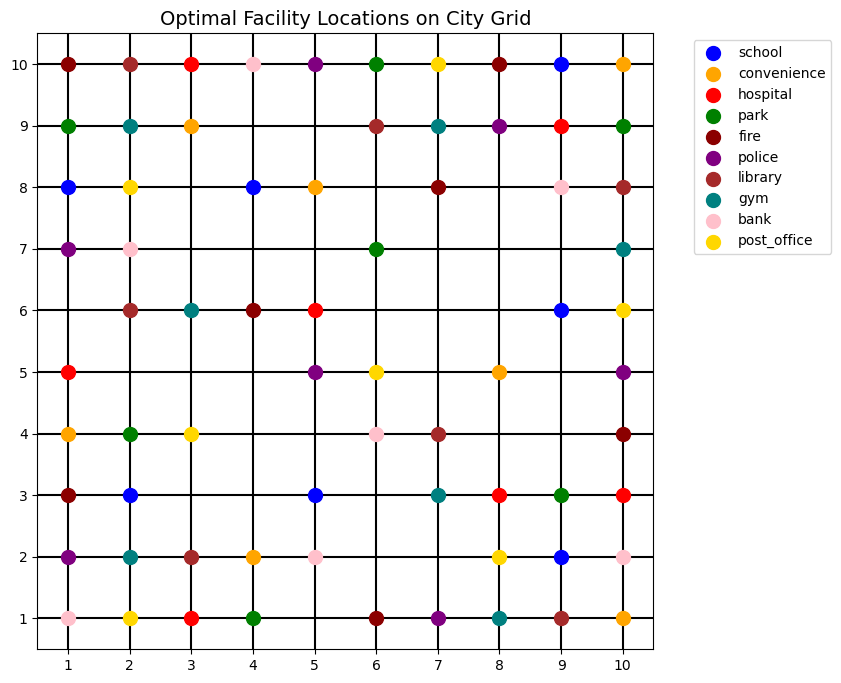

In [11]:
# Plot the 10x10 grid
plt.figure(figsize=(8, 8))
plt.grid(color='black', linestyle='-', linewidth=1.5, zorder=0)
plt.xlim(0.5, 10.5)
plt.ylim(0.5, 10.5)
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))
plt.gca().set_aspect('equal')

# Define color per facility type
facility_colors = {
    'school': 'blue',
    'convenience': 'orange',
    'hospital': 'red',
    'park': 'green',
    'fire': 'darkred',
    'police': 'purple',
    'library': 'brown',
    'gym': 'teal',
    'bank': 'pink',
    'post_office': 'gold'
}

# Plot facilities found in the optimal solution
for b in facility_names:
    for (i, j) in coords:
        if y_opt[b][i, j].X > 0.5:   # Facility exists
            print("%s at (%d,%d)" % (b, i, j))
            plt.scatter(i, j, color=facility_colors[b], s=100, label=b if b not in plt.gca().get_legend_handles_labels()[1] else "", zorder=3)

plt.title("Optimal Facility Locations on City Grid", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()